# Deploy Model Prediksi Solar Panel Kota Bandung

- Nama: Wildan Fadhil Nazaruddin
- Email: wildanfadhil76@gmail.com

### Persiapan

## Menyiapkan library yang dibutuhkan

In [76]:
# Manipulasi Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
import os

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

# Evaluasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Save Model
import pickle

import warnings
warnings.filterwarnings('ignore')

### Menyiapkan data yang akan digunakan

In [33]:
df = pd.read_csv('../data/data_bmkg_cleaned_2019_2025.csv')
df_model = df.copy()

## Data Understanding

Adapun kolom-kolom yang terdapat pada dataset adalah sebagai berikut:

| Kolom      | Penjelasan                                                         |
|------------|--------------------------------------------------------------------|
| Hari       | Tanggal observasi (format: dd-mm-yyyy)                             |
| Tn         | Suhu minimum harian (°C)                                           |
| Tx         | Suhu maksimum harian (°C)                                          |
| Tavg       | Suhu rata-rata harian (°C)                                         |
| RH_avg     | Kelembapan rata-rata harian (%)                                    |
| RR         | Curah hujan harian (mm)                                            |
| ss         | Lama penyinaran matahari harian (jam)                              |
| ff_x       | Kecepatan angin maksimum harian (m/s)                              |
| ddd_x      | Arah angin saat kecepatan maksimum (°)                             |
| ff_avg     | Kecepatan angin rata-rata harian (m/s)                             |
| ddd_car    | Arah angin terbanyak/dominan harian (°)                            |

---

### Background Proyek

Bandung sebagai kota besar di Indonesia memiliki dinamika cuaca yang penting untuk berbagai sektor, seperti energi terbarukan (panel surya), transportasi, dan perencanaan kota. Data cuaca historis dari BMKG dapat memberikan insight penting untuk prediksi dan pengambilan keputusan.

### Tujuan Proyek

1. Prediksi lama penyinaran matahari dapat digunakan untuk estimasi potensi energi surya harian.
2. Insight ini mendukung perencanaan pemasangan solar panel dan strategi zero emisi di Kota Bandung.
3. Data dan model dapat diintegrasikan ke dashboard interaktif untuk monitoring dan pengambilan keputusan.

---

In [34]:
# menampilkan semua kolom
pd.set_option('display.max_columns', None)
# melihat sample data
df.head()

,Hari,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
0,2019-01-01,21.8,28.0,23.0,79.0,0.0,1.7,3.0,280.0,2.0,W
1,2019-01-02,20.8,31.0,24.0,74.0,13.5,1.9,8.0,250.0,4.0,W
2,2019-01-03,20.7,30.6,24.1,76.0,0.8,7.2,7.0,260.0,4.0,W
3,2019-01-04,20.0,30.8,24.2,69.0,0.0,5.5,5.0,210.0,3.0,W
4,2019-01-05,20.0,31.7,24.8,70.0,0.0,8.5,5.0,300.0,3.0,C


In [35]:
# melihat informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Hari     2167 non-null   object 
 1   Tn       2167 non-null   float64
 2   Tx       2167 non-null   float64
 3   Tavg     2167 non-null   float64
 4   RH_avg   2167 non-null   float64
 5   RR       2167 non-null   float64
 6   ss       2167 non-null   float64
 7   ff_x     2167 non-null   float64
 8   ddd_x    2167 non-null   float64
 9   ff_avg   2167 non-null   float64
 10  ddd_car  2167 non-null   object 
dtypes: float64(9), object(2)
memory usage: 186.4+ KB


Seluruh tipe data sudah sesuai

In [36]:
# melihat missing value
df.isnull().sum()

Hari       0
Tn         0
Tx         0
Tavg       0
RH_avg     0
RR         0
ss         0
ff_x       0
ddd_x      0
ff_avg     0
ddd_car    0
dtype: int64

data tidak terdapat missing valeu

In [37]:
# melihat duplikat data
df.duplicated().sum()

np.int64(2)

terindikasi 2 data terdapat duplikasi

In [38]:
# statistik deskriptif
df.describe()

,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,19.902607,29.927319,24.115159,77.115598,123.599235,5.099954,3.668205,201.344255,1.251038
std,3.658010,1.586112,1.123219,7.860401,685.857067,2.459028,1.334468,84.907331,0.876342
min,0.000000,24.200000,20.900000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.600000,29.000000,23.400000,72.000000,0.000000,3.400000,3.000000,120.000000,1.000000
50%,20.400000,30.000000,24.100000,78.000000,1.333333,5.300000,3.000000,230.000000,1.000000
75%,21.000000,30.800000,24.700000,83.000000,9.600000,7.100000,5.000000,270.000000,2.000000
max,91.600000,36.000000,29.600000,96.000000,6667.500000,9.800000,12.000000,360.000000,6.000000


In [39]:
# melihat nilai untuk kolom ss
df['ss'].value_counts()

ss
8.000000    69
0.000000    62
5.000000    44
5.800000    44
6.000000    41
            ..
5.180645     1
5.035484     1
4.890323     1
4.745161     1
4.150000     1
Name: count, Length: 162, dtype: int64

## Data Cleaning 

In [60]:
# Menampilkan kolom mana saja yang menyebabkan duplikasi pada df
dupe_rows = df_model[df_model.duplicated(keep=False)]
if not dupe_rows.empty:
    dupe_columns = dupe_rows.drop_duplicates().columns[(dupe_rows.nunique() != len(dupe_rows))]
    print("Kolom yang teridentifikasi menyebabkan duplikasi:")
    print(list(dupe_columns))
    display(dupe_rows)
else:
    print("Tidak ada baris duplikat pada dataframe.")

Kolom yang teridentifikasi menyebabkan duplikasi:
['Hari', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg', 'ddd_car']


,Hari,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
920,2021-08-07,18.0,28.8,22.6,80.0,0.0,7.8,3.0,160.0,1.0,C
921,2021-08-07,18.0,28.8,22.6,80.0,0.0,7.8,3.0,160.0,1.0,C
963,2021-09-18,19.8,31.6,25.3,65.0,0.0,8.3,3.0,112.0,2.0,E
964,2021-09-18,19.8,31.6,25.3,65.0,0.0,8.3,3.0,112.0,2.0,E


In [61]:
# menghapus nilai duplikat
df_model = df_model.drop_duplicates()

In [62]:
# Menampilkan kolom mana saja yang menyebabkan duplikasi pada df
dupe_rows = df_model[df_model.duplicated(keep=False)]
if not dupe_rows.empty:
    dupe_columns = dupe_rows.drop_duplicates().columns[(dupe_rows.nunique() != len(dupe_rows))]
    print("Kolom yang teridentifikasi menyebabkan duplikasi:")
    print(list(dupe_columns))
    display(dupe_rows)
else:
    print("Tidak ada baris duplikat pada dataframe.")

Tidak ada baris duplikat pada dataframe.


In [63]:
# Ubah kolom 'Hari' di df_model ke datetime, lalu ekstrak hari, bulan, dan tahun
df_model['Hari'] = pd.to_datetime(df_model['Hari'], format='%Y-%m-%d')
df_model['Tahun'] = df_model['Hari'].dt.year
df_model['Bulan'] = df_model['Hari'].dt.month
df_model['Tanggal'] = df_model['Hari'].dt.day

# Cek hasil
df_model[['Hari', 'Tahun', 'Bulan', 'Tanggal']].head()

,Hari,Tahun,Bulan,Tanggal
0,2019-01-01,2019,1,1
1,2019-01-02,2019,1,2
2,2019-01-03,2019,1,3
3,2019-01-04,2019,1,4
4,2019-01-05,2019,1,5


## EDA

In [51]:
# Cek distribusi kategori ss per hari (berapa hari pada tiap kategori ss)
ss_kategori_harian = df['ss_kategori'].value_counts().sort_index()

print("Distribusi jumlah hari pada setiap kategori lama penyinaran matahari (ss):")
for kategori, jumlah in ss_kategori_harian.items():
    print(f"{kategori}: {jumlah} hari")

Distribusi jumlah hari pada setiap kategori lama penyinaran matahari (ss):
0-2 jam: 279 hari
2-4 jam: 394 hari
4-6 jam: 638 hari
6-8 jam: 555 hari
8-10 jam: 301 hari
10-12 jam: 0 hari
>12 jam: 0 hari


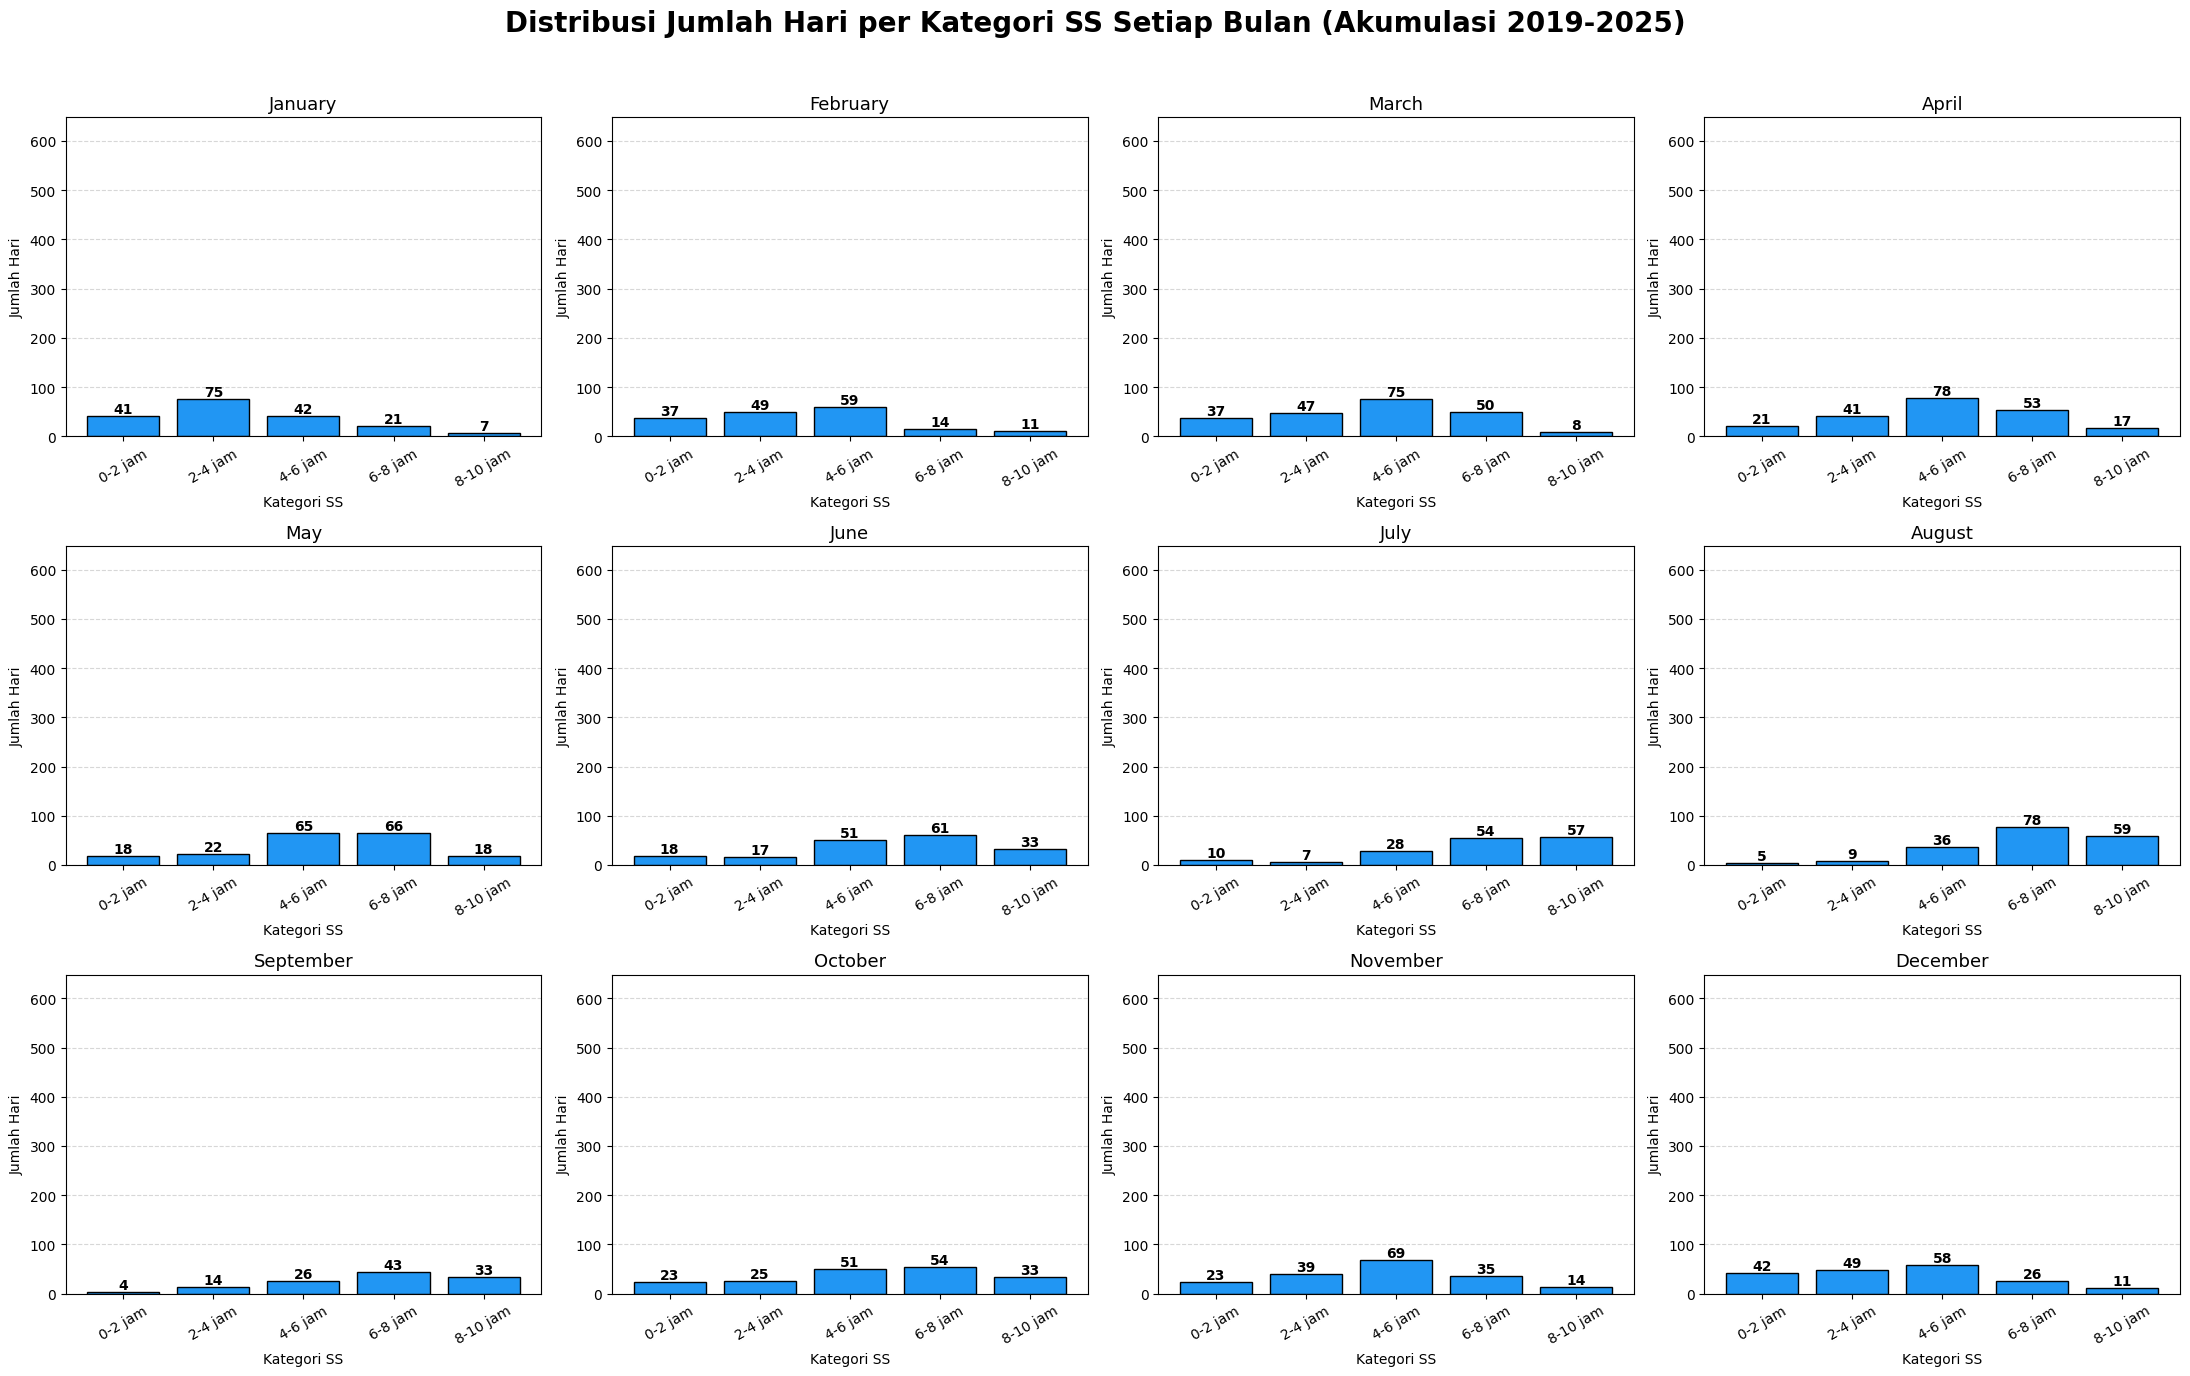

In [ ]:
# Pastikan kolom tanggal sudah datetime
df['Hari'] = pd.to_datetime(df['Hari'], format='%Y-%m-%d')
df['BulanNama'] = df['Hari'].dt.strftime('%B')  # Nama bulan (Januari, Februari, ...)
df['BulanAngka'] = df['Hari'].dt.month          # Untuk urutan plot

# Siapkan kategori ss (urutkan sesuai urutan kategori Anda)
kategori_ss = df['ss_kategori'].unique()
kategori_ss = sorted(kategori_ss, key=lambda x: float(x.split('-')[0].replace('>','').replace('<','').replace(' jam','')) if '-' in x else 999)

# Urutkan nama bulan sesuai kalender
bulan_order = ['January','February','March','April','May','June','July','August','September','October','November','December']

fig, axes = plt.subplots(3, 4, figsize=(22, 14))
fig.suptitle('Distribusi Jumlah Hari per Kategori SS Setiap Bulan (Akumulasi 2019-2025)', fontsize=20, fontweight='bold')

for i, bulan in enumerate(bulan_order):
    ax = axes.flatten()[i]
    # Filter data untuk bulan tertentu (semua tahun)
    data_bulan = df[df['BulanNama'] == bulan]['ss_kategori'].value_counts().reindex(kategori_ss, fill_value=0)
    bars = ax.bar(kategori_ss, data_bulan.values, color='#2196F3', edgecolor='black')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_title(bulan, fontsize=13)
    ax.set_xlabel('Kategori SS')
    ax.set_ylabel('Jumlah Hari')
    ax.tick_params(axis='x', rotation=30)
    ax.set_ylim(0, df['ss_kategori'].value_counts().max() + 10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

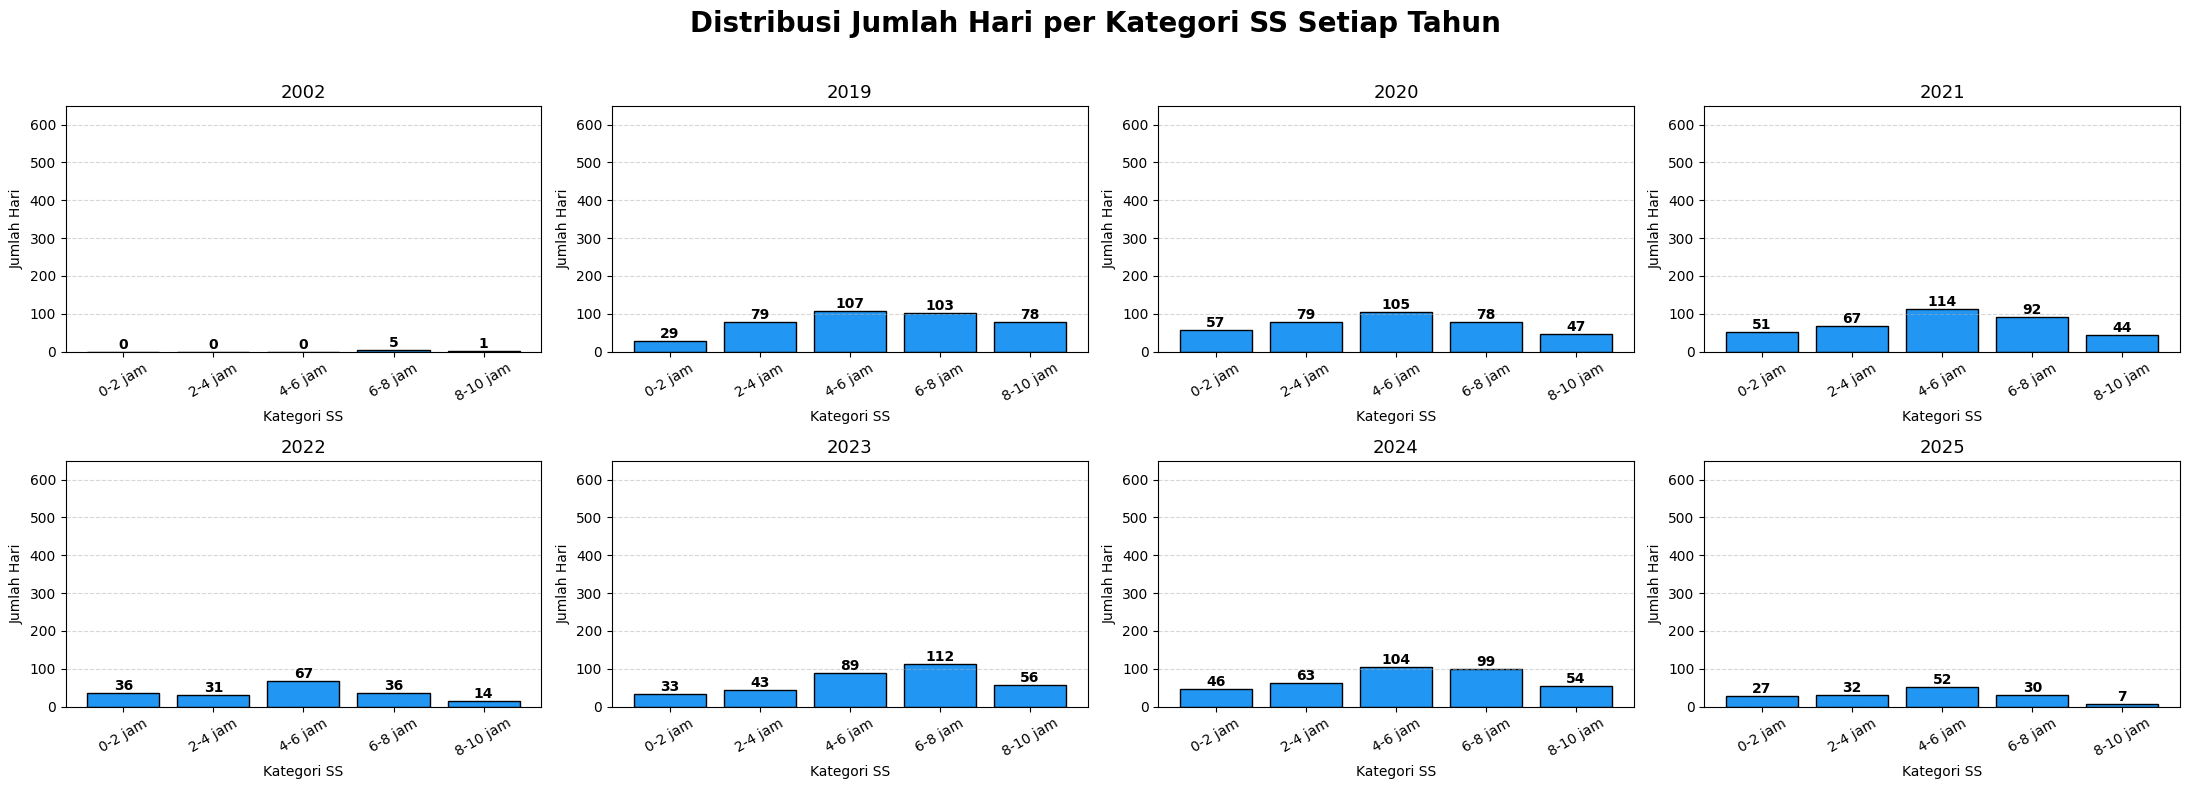

In [56]:
# Pastikan kolom tanggal sudah datetime
df['Hari'] = pd.to_datetime(df['Hari'], format='%Y-%m-%d')
df['Tahun'] = df['Hari'].dt.year

# Siapkan kategori ss (urutkan sesuai urutan kategori Anda)
kategori_ss = df['ss_kategori'].unique()
kategori_ss = sorted(kategori_ss, key=lambda x: float(x.split('-')[0].replace('>','').replace('<','').replace(' jam','')) if '-' in x else 999)

tahun_unik = sorted(df['Tahun'].unique())

fig, axes = plt.subplots(2, 4, figsize=(22, 8))
fig.suptitle('Distribusi Jumlah Hari per Kategori SS Setiap Tahun', fontsize=20, fontweight='bold')

for i, tahun in enumerate(tahun_unik):
    ax = axes.flatten()[i]
    data_tahun = df[df['Tahun'] == tahun]['ss_kategori'].value_counts().reindex(kategori_ss, fill_value=0)
    bars = ax.bar(kategori_ss, data_tahun.values, color='#2196F3', edgecolor='black')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_title(str(tahun), fontsize=13)
    ax.set_xlabel('Kategori SS')
    ax.set_ylabel('Jumlah Hari')
    ax.tick_params(axis='x', rotation=30)
    ax.set_ylim(0, df['ss_kategori'].value_counts().max() + 10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Kosongkan subplot jika tahun < 8
for j in range(len(tahun_unik), 8):
    axes.flatten()[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

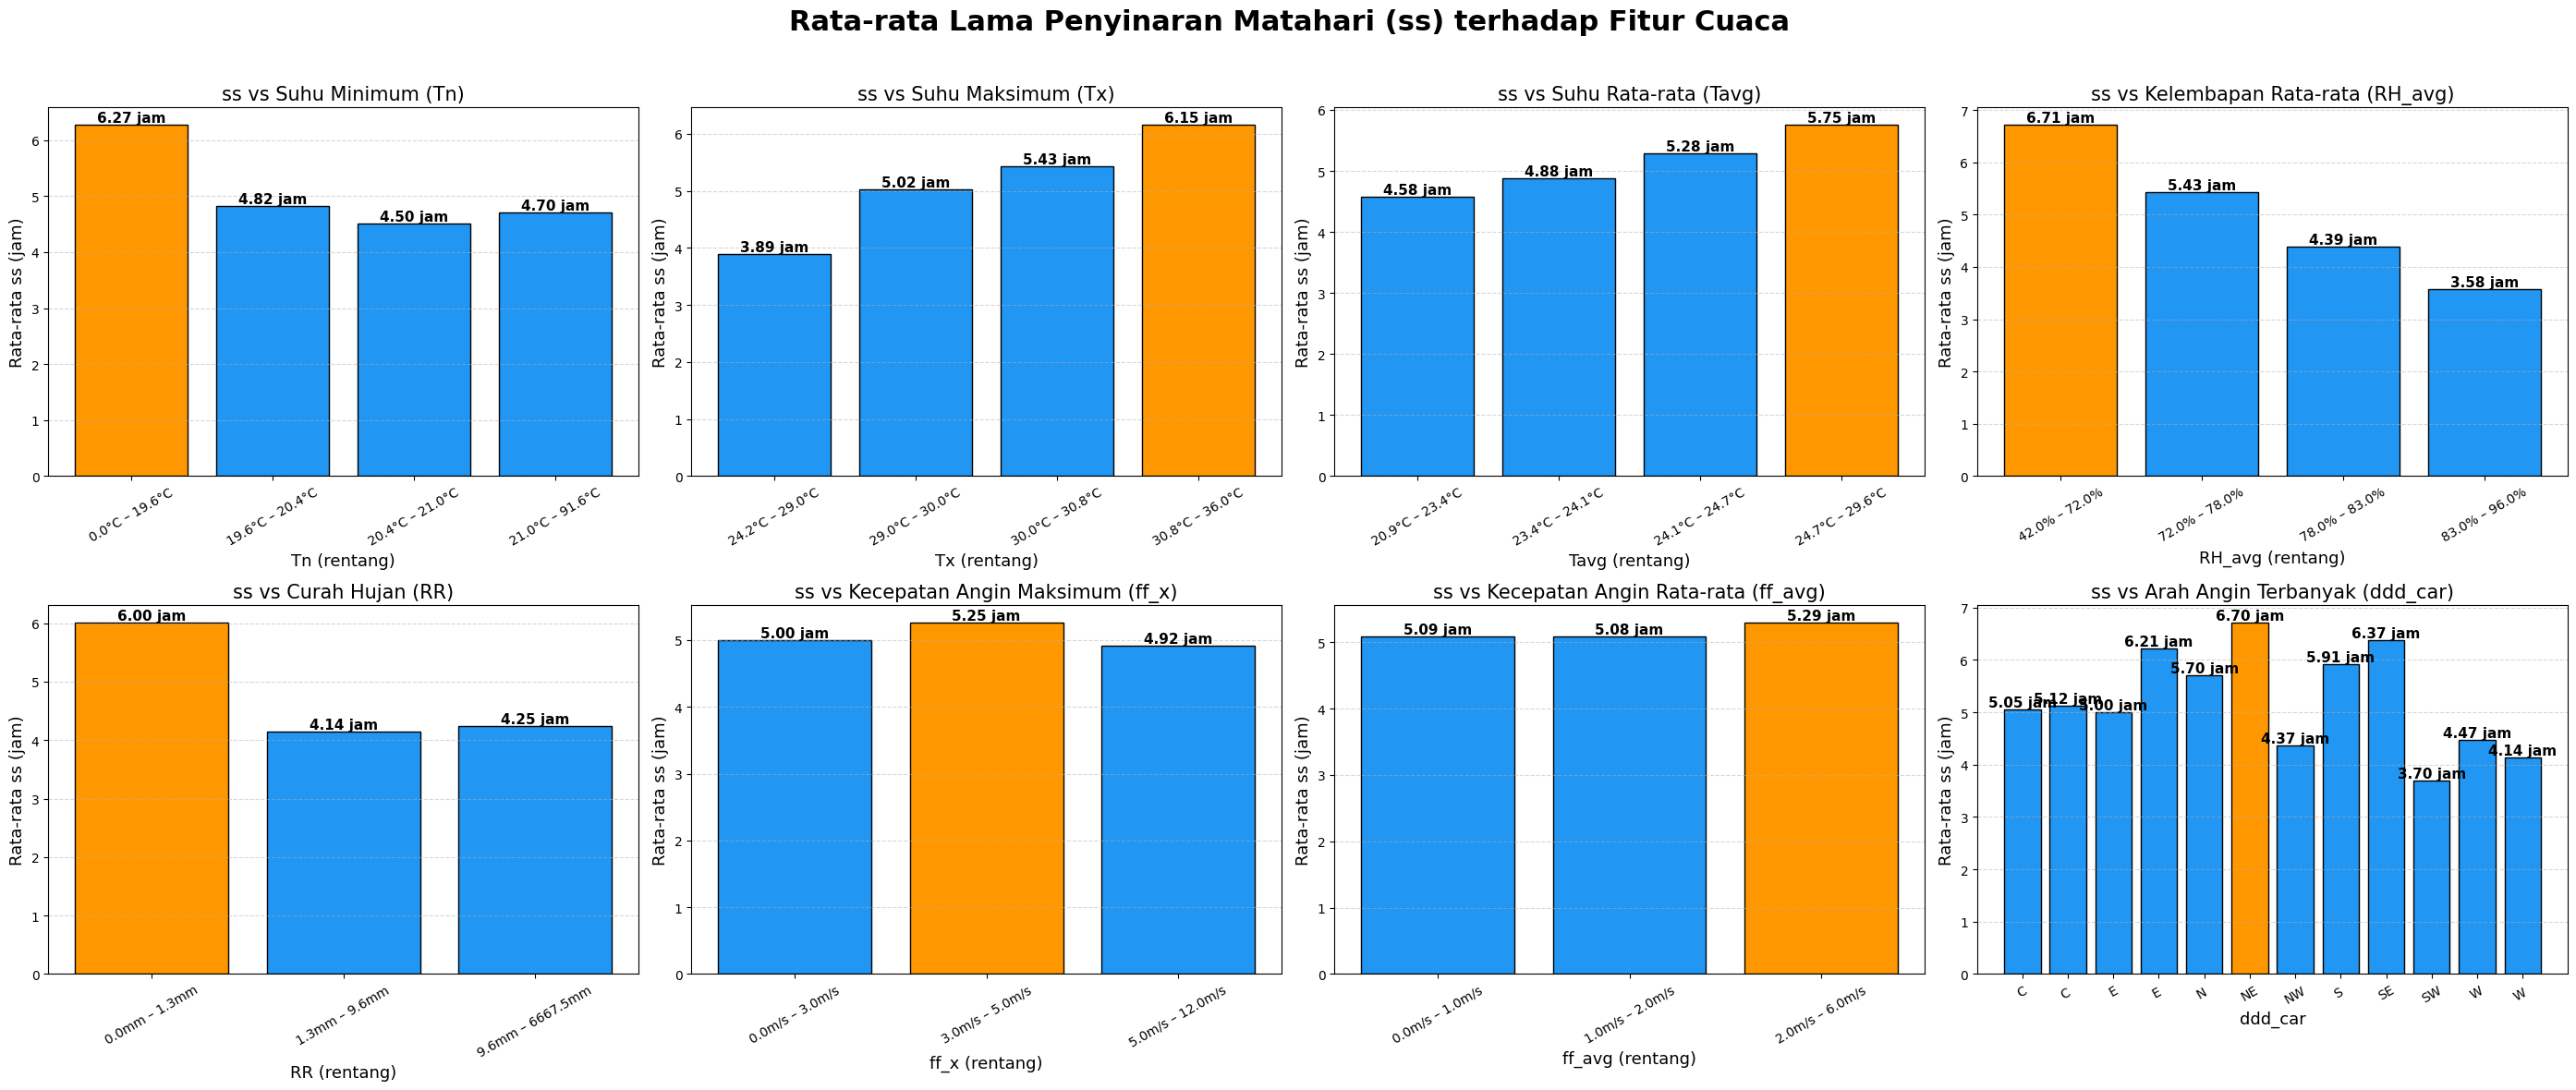

In [41]:
# melihat deskripsi data dengan kategori ss
plot_features = [
    ('Tn', 'ss vs Suhu Minimum (Tn)', '°C'),
    ('Tx', 'ss vs Suhu Maksimum (Tx)', '°C'),
    ('Tavg', 'ss vs Suhu Rata-rata (Tavg)', '°C'),
    ('RH_avg', 'ss vs Kelembapan Rata-rata (RH_avg)', '%'),
    ('RR', 'ss vs Curah Hujan (RR)', 'mm'),
    ('ff_x', 'ss vs Kecepatan Angin Maksimum (ff_x)', 'm/s'),
    ('ff_avg', 'ss vs Kecepatan Angin Rata-rata (ff_avg)', 'm/s'),
    ('ddd_car', 'ss vs Arah Angin Terbanyak (ddd_car)', '')
]

fig, axes = plt.subplots(2, 4, figsize=(28, 12))
fig.suptitle('Rata-rata Lama Penyinaran Matahari (ss) terhadap Fitur Cuaca', fontsize=22, fontweight='bold')

for ax, (col, title, satuan) in zip(axes.flatten(), plot_features):
    if df[col].dtype in ['int64', 'float64']:
        # Binning numerik menjadi 4 kategori (quartile)
        bin_col = f'{col}_bin'
        df[bin_col], bins = pd.qcut(df[col], q=4, retbins=True, duplicates='drop')
        mean_ss = df.groupby(bin_col)['ss'].mean().reset_index()
        # Buat label informatif untuk tiap bin
        bin_labels = []
        for i in range(len(bins)-1):
            bin_labels.append(f"{bins[i]:.1f}{satuan} – {bins[i+1]:.1f}{satuan}")
        mean_ss['label'] = bin_labels
        highlight = mean_ss['ss'].idxmax()
        bar_colors = ['#FF9800' if i == highlight else '#2196F3' for i in range(len(mean_ss))]
        bars = ax.bar(mean_ss['label'], mean_ss['ss'], color=bar_colors, edgecolor='black')
        # Label nilai di atas bar
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f} jam",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.set_xlabel(f'{col} (rentang)', fontsize=13)
    else:
        # Bar chart rata-rata ss per kategori (tanpa encoding)
        mean_ss = df.groupby(col)['ss'].mean().reset_index()
        highlight = mean_ss['ss'].idxmax()
        bar_colors = ['#FF9800' if i == highlight else '#2196F3' for i in range(len(mean_ss))]
        bars = ax.bar(mean_ss[col].astype(str), mean_ss['ss'], color=bar_colors, edgecolor='black')
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f} jam",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.set_xlabel(col, fontsize=13)
    ax.set_title(title, fontsize=15)
    ax.set_ylabel('Rata-rata ss (jam)', fontsize=13)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Data Preparation / Preprocessing

In [65]:
# melihat nilai untuk tiap kategori baik numerik maupun kategorik
numeric = df_model.select_dtypes(exclude=['object']).columns
categoric = df_model.select_dtypes(include=['object']).columns

print("jumlah kolom numerik", len(numeric))
print("jumlah kolom kategorik", len(categoric))

jumlah kolom numerik 13
jumlah kolom kategorik 1


In [66]:
print(f'Jumlah baris: {len(df_model)}')

outlier = []
no_outlier = []
is_outlier = []
low_lim = []
high_lim = []

filtered_entries = np.array([True] * len(df_model))
for col in numeric:
    Q1 = df_model[col].quantile(0.25)
    Q3 = df_model[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    # mulai filter outlier
    filter_outlier = ((df_model[col] >= low_limit) & (df_model[col] <= high_limit))
    outlier.append(len(df_model[~filter_outlier]))
    no_outlier.append(len(df_model[filter_outlier]))
    is_outlier.append(df_model[col][~filter_outlier].any())
    low_lim.append(low_limit)
    high_lim.append(high_limit)

    filtered_entries = ((df_model[col] >= low_limit) & (df_model[col] <= high_limit)) & filtered_entries

print("Outlier All Data :", len(df_model[~filtered_entries]))
print("Not Outlier All Data :", len(df_model[filtered_entries]))
print()

# Pastikan numeric diubah ke list jika masih berupa Index
pd.DataFrame({
    "Column Name": list(numeric),
    "is Outlier": is_outlier,
    "Lower Limit": low_lim,
    "Upper Limit": high_lim,
    "Outlier": outlier,
    "No Outlier": no_outlier
})

Jumlah baris: 2165
Outlier All Data : 504
Not Outlier All Data : 1661



,Column Name,is Outlier,Lower Limit,Upper Limit,Outlier,No Outlier
0,Hari,True,2015-01-25 00:00:00,2029-03-28 00:00:00,6,2159
1,Tn,True,17.5,23.1,118,2047
2,Tx,True,26.3,33.5,77,2088
3,Tavg,True,21.45,26.65,52,2113
4,RH_avg,True,55.5,99.5,29,2136
5,RR,True,-14.4,24.0,251,1914
6,ss,False,-2.15,12.65,0,2165
7,ff_x,True,0.0,8.0,7,2158
8,ddd_x,False,-105.0,495.0,0,2165
9,ff_avg,True,-0.5,3.5,27,2138


### Label Encoding

In [67]:
# membuat label encoder untuk kolom kategorik
label_encoder = LabelEncoder()

df_model['ddd_car'] = label_encoder.fit_transform(df_model['ddd_car'])

In [69]:
df_encoding = df_model.copy()

### Data Spliting

In [79]:
X = df_encoding.drop(['ss', 'Hari'], axis=1)  # drop kolom target dan kolom yang tidak dipakai
Y = df_encoding['ss']

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [81]:
print("Training :", X_train.shape)
print("Testing :", X_test.shape)

Training : (1732, 12)
Testing : (433, 12)


df_model

In [88]:
import numpy as np

# Urutkan data berdasarkan tanggal
df_encoding = df_encoding.sort_values('Hari')

# Pilih fitur yang akan digunakan (drop kolom yang tidak dipakai)
features = [col for col in df_encoding.columns if col not in ['ss', 'Hari']]
X_all = df_encoding[features].values
y_all = df_encoding['ss'].values

# Fungsi untuk membuat window time series
def create_sequences(X, y, window_size=7):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 7  # contoh: 7 hari ke belakang
X_seq, y_seq = create_sequences(X_all, y_all, window_size=window_size)

# Split train-test
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [90]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(window_size, X_train.shape[2]),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(
        hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='solar_panel'
)

tuner.search(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Dapatkan model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluasi
y_pred = best_model.predict(X_test).flatten()
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

Trial 10 Complete [00h 00m 09s]
val_loss: 6.249838352203369

Best val_loss So Far: 4.146890640258789
Total elapsed time: 00h 01m 52s
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE: 4.0433559125488365
MAE: 1.6307163022182607
R2: 0.22805592129227725


In [83]:
df_model.head()

,Hari,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,Tahun,Bulan,Tanggal
0,2019-01-01,21.8,28.0,23.0,79.0,0.0,1.7,3.0,280.0,2.0,11,2019,1,1
1,2019-01-02,20.8,31.0,24.0,74.0,13.5,1.9,8.0,250.0,4.0,11,2019,1,2
2,2019-01-03,20.7,30.6,24.1,76.0,0.8,7.2,7.0,260.0,4.0,11,2019,1,3
3,2019-01-04,20.0,30.8,24.2,69.0,0.0,5.5,5.0,210.0,3.0,11,2019,1,4
4,2019-01-05,20.0,31.7,24.8,70.0,0.0,8.5,5.0,300.0,3.0,1,2019,1,5
